In [1]:
# !pip install -r requirements.txt
!pip install ipykernel langchain_experimental llama-index-vector-stores-pinecone ipykernel PyMuPDF pinecone-client pypdf faiss-cpu langchain_community transformers sentence_transformers
!pip install llama_index.embeddings.huggingface
!pip install transformers pinecone-client pypdf faiss-cpu langchain langchain-openai langchain-community
!pip install torch sentence-transformers scikit-learn pandas numpy nltk openai python-dotenv llama-index pymupdf
!pip install huggingface_hub datasets IProgress

  Using cached llama_index_embeddings_huggingface-0.6.1-py3-none-any.whl.metadata (458 bytes)
Using cached llama_index_embeddings_huggingface-0.6.1-py3-none-any.whl (8.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import io
import json
import math
import os
import re
import sqlite3
import time

import datasets
import dotenv
import faiss
import fitz
import huggingface_hub
import langchain
import langchain_community
import nltk
import numpy as np
import openai
import pandas as pd
import pinecone
import pypdf
import requests
import torch
import transformers
from dotenv import load_dotenv
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
from llama_index.core import (SimpleDirectoryReader, StorageContext,
                              VectorStoreIndex)
from llama_index.core.extractors import (QuestionsAnsweredExtractor,
                                         TitleExtractor)
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.schema import TextNode
# sentence transformers
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.vector_stores.pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from google.colab import userdata

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Chunk text and store in pinecone db - Run Once
load_dotenv()

openai_api_key = userdata.get('OPENAI_API_KEY')
pinecone_api_key=userdata.get('PINECONE_KEY')

# configure Pinecone client
pc = Pinecone(api_key=pinecone_api_key)

PDF_PATH = "/content/drive/MyDrive/GenAI Image Generation/Product_review.pdf"
doc = fitz.open(PDF_PATH)


# # parser to split up product review:
text_parser = TokenTextSplitter(
    chunk_size=1024
)

text_chunks = []
doc_idxs = []


for doc_idx, page in enumerate(doc):
    page_text = page.get_text("text")
    cur_text_chunks = text_parser.split_text(page_text)
    text_chunks.extend(cur_text_chunks)
    doc_idxs.extend([doc_idx] * len(cur_text_chunks))

nodes = []

for idx, text_chunk in enumerate(text_chunks):
    node = TextNode(
        text=text_chunk,
    )
    src_doc_idx = doc_idxs[idx]
    src_page = doc[src_doc_idx]
    nodes.append(node)

use_serverless = True

spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )

# specify the Pinecone environment to use:
if use_serverless:
    spec = pinecone.ServerlessSpec(cloud='aws', region="us-east-1")
else:
   spec = pinecone.PodSpec(environment=environment)

# Name our Pinecone Index:
index_name = "hw04"

# If a Pinecone index of the same name already exists, delete it:
if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)


# define similarity and additional parameters for the vector store index:
dimensions = 1536              # the dimensions of the index need to align with the LLM we are using for the RAG system. For example, if using openAI then dimenion = 1536. If using Llama2, then dimension = 384.

# "dotproduct" is one similarity metric we can for the vector store index. We can use different distance metrics to measure the similarity between vector embeddings and user queries. This is where we define what similarity metric we are going to use for the vector store.
# "cosine" is another similarity metric we can use for the vector store index.
# "euclidean" is another similarity metric we can use for the vector store index.

pc.create_index(
    name=index_name,
    dimension=dimensions,
    metric="cosine",          # we can use different distance metrics to measure the similarity between vector embeddings and user queries. this is where we define what similarity metric we are going to use for the vector store.
    spec=spec
)

# wait for index to be ready before connecting
while not pc.describe_index(index_name).status['ready']:
   time.sleep(1)

for index in pc.list_indexes():
    print(index['name'])


pc.describe_index("hw04")


pc_index = pc.Index(index_name)  # create an index to use in the vector store


vector_store = PineconeVectorStore(pinecone_index=pc_index)    # this function creates a vector store where we will add and store embeddings

pc_index = pc.Index(index_name)  # create an index to use in the vector store
vector_store = PineconeVectorStore(pinecone_index=pc_index)    # this function creates a vector store where we will add and store embeddings

pc_index.describe_index_stats()

llm = OpenAI(model="gpt-3.5-turbo",
             api_key=openai_api_key)

extractors = [
    TitleExtractor(nodes=5, llm=llm),
    QuestionsAnsweredExtractor(questions=3, llm=llm),
]

pipeline = IngestionPipeline(
    transformations=extractors,
)
nodes = await pipeline.arun(nodes=nodes, in_place=False)

model_ada="text-embedding-ada-002"
small_txt_embedmodel_="text-embedding-3-small"


embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_key=openai_api_key)

for node in nodes:
    node_embedding = embed_model.get_text_embedding(
        node.get_content(metadata_mode="all")
    )
    node.embedding = node_embedding

vector_store.add(nodes)


pc_index.describe_index_stats()


print(nodes[0].metadata)

print(nodes[0])

hw02
hw04


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


Upserted vectors:   0%|          | 0/8 [00:00<?, ?it/s]

{'document_title': 'Office Chair and Monitor Reviews: Comfort, Visuals, Connectivity, and Value', 'questions_this_excerpt_can_answer': '1. How long does it typically take to assemble the Mesh Office Chair Mid Back Swivel Ergonomic Home Desk Chair with Flip-up Arms?\n2. What are some common praises from customers who have purchased the Mesh Office Chair, in terms of comfort and quality?\n3. How do customers describe the shipping and delivery experience when purchasing the Mesh Office Chair?'}
Node ID: bf64a944-a769-464f-abf9-53a3ef720cb1
Text: Product 1: Mesh Office Chair Mid Back Swivel Ergonomic Home
Desk Chair with Flip-up Arms    Description:   ● The computer desk
chair is made of the high-density and breathable mesh  back with
lumbar support and thick cushion to provide you the most  comfortable
posture. The thickened explosion-proof seat plate give you more
comfort and double ...


In [5]:
#Function to generate image prompt for product based on product name, returns prompt string

def get_image_prompt_for_product(product_name: str) -> str:

  client = openai.OpenAI(api_key=openai_api_key)

  # query the vector store with the 5 queries above (don't forget to record the responses in your homework submission!)

  k = 5
  queries = [
      f"Summarize the product description and customer reviews in a concise bullet-point format highlighting the key features and overall user sentiment for {product_name}",

  ]
  responses = []


  # Choose one of these models:
  embed_model_ada = "text-embedding-ada-002"
  embed_model_3_small = "text-embedding-3-small"

  for query in tqdm(queries):
      res = client.embeddings.create(
          input=[query],
          model=embed_model_3_small
      )

      # Retrieve from Pinecone
      xq = res.data[0].embedding  # res['data'][0]['embedding']

      # Get relevant contexts (including the questions)
      res2 = pc_index.query(vector=xq, top_k=k, include_metadata=True)

      # Add response results
      responses.append(res2)

  chat_responses = []
  for query, response in zip(queries, responses):
      chat_response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
          {"role": "system", "content": "Instruction: use the information in {response} to answer the user's question."},
          {"role": "user", "content": query},
          {"role": "assistant", "content": str(response)},
          {"role": "user", "content": "What is the answer?"}
      ]
      )
      chat_responses.append(chat_response.choices[0].message.content)

  print(chat_responses[0])
  return chat_responses[0]

In [6]:
#Example
prom = get_image_prompt_for_product("bomber jacket")
print (prom)


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Here is a concise summary of the product description and customer reviews for a bomber jacket:

**Product Description:**
- Model: Pyramex RJ3210 High Visibility Lime Green Bomber Jacket
- Features:
  - Class 3 weatherproof, insulated jacket with quilted liner
  - Lime green with black bottom
  - Attachable, concealed hood
  - Zipper front closure; elastic at waist and wrist cuffs
  - 5 pockets (4 outside, 1 inside) with mic tabs and pencil pockets
  - Clear ID badge holder suitable for a cell phone or radio
  - Meets ANSI/ISEA 107-2015 Type R, Class 3 Standards
  - Available in sizes Small to 6XLarge

**Customer Reviews:**
- Overall Positive Sentiment:
  - Many customers find the jacket comfortable, warm, and well-made.
  - Praised for true-to-size fitting and good value for money.
  - Fast shipping is frequently mentioned.
- Mixed Feedback on Hood:
  - Some customers find the hood bulky when folded or not insulated sufficiently.
  - Appreciated for it being concealable.
- Negative Exp

In [6]:
from huggingface_hub import login

from google.colab import userdata

login(userdata.get('HF_KEY'))

In [7]:
from openai import OpenAI
import os

# Initialize the OpenAI client with your API key
client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

In [8]:
from PIL import Image
from IPython.display import display
from diffusers import StableDiffusionPipeline
import torch

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [9]:
import torch

print("Using GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Using GPU: NVIDIA L4


In [10]:
#Function to clean prompt: remove spaces and special characters from prompt

def create_prompt_image_generation(text: str) -> str:
    # Replace newline characters with a space
    no_newlines = text.replace('\n', ' ')
    # Remove inverted commas (both single and double quotes)
    cleaned_text = no_newlines.replace('"', '').replace("'", "")
    # Remove any extra spaces and return a single paragraph
    single_paragraph = ' '.join(cleaned_text.split())
    return single_paragraph


In [11]:
import requests

#Function to save Dalle image to Google drive path

def save_image_from_url(image_url: str, save_path: str):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Image successfully saved to {save_path}")
    else:
        print(f"Failed to download image. Status code: {response.status_code}")


In [12]:
# Load the Stable Diffusion model (adjust torch_dtype and device as needed)

model_id = "Manojb/stable-diffusion-2-1-base"

print(f"Loading {model_id}...")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    dtype=torch.float16
)

pipe = pipe.to("cuda")

print("Stable Diffusion 2.1 Base loaded successfully and ready for fast generation.")

Loading Manojb/stable-diffusion-2-1-base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Stable Diffusion 2.1 Base loaded successfully and ready for fast generation.


In [17]:
def generate_image_sd(prompt_item: str, prompt_final: str, prompt_item_num: str):
    """
    Generates images using Stable Diffusion (via the global 'pipe' object).

    For Stable Diffusion:
      - The image is generated using the diffusers pipeline.
      - The image is saved locally with the filename format:
        "{prompt_item}_sd_{prompt_item_num}.png"
    """
    # --- Stable Diffusion Image Generation ---
    cleaned_prompt_item = prompt_item.replace(" ", "_")

    print("Generating Stable Diffusion Image...")

    # Generate the image using the prompt_final
    sd_image = pipe(
        prompt_final,
        num_inference_steps=25,
        guidance_scale=8.0
    ).images[0]

    # Create the image name for stable diffusion
    image_name_sd = "/content/drive/MyDrive/GenAI Image Generation/image/"+f"{prompt_item}_sd_{prompt_item_num}.png"
    sd_image.save(image_name_sd)
    print(f"Stable Diffusion image saved as {image_name_sd}")

    return image_name_sd

In [19]:
#Function to generate image from Dalle based on prompt item name, prompt item number - image name parameter, final prompt text
#Returns file path of saved image from Dalle

def generate_image_dalle(prompt_item: str, prompt_final: str, prompt_item_num: str) -> str:
    """
    Generates images using DALL-E based on the provided prompt.

    For DALL-E:
      - The image is generated using the DALL-E client.
      - The URL of the generated image is printed.

    Note: Ensure that the DALL-E client (referred to as 'client') is properly initialized before calling this function.
    """


    dalle_prompt="The image should be clean and professional, with no text, words, labels, or reviews included in the image. "+prompt_final

    # --- DALL-E Image Generation ---
    # Ensure that 'client' is initialized for DALL-E image generation.
    response = client.images.generate(
        model="dall-e-3",
        prompt=dalle_prompt,
        size='1024x1024',
        style='vivid',
        quality='hd',
        n=1
    )
    image_url = response.data[0].url
    print("DALL-E image URL:", image_url)
    image_name_dalle ="/content/drive/MyDrive/GenAI Image Generation/image/"+f"{prompt_item}_dalle_{prompt_item_num}.png"
    save_image_from_url(image_url, image_name_dalle)
    return image_name_dalle

In [15]:
#Agent function to create image based on product name, returns file path of generated Dalle image

def agent_generate_image_product_dalle(product_name: str) -> str:

  #Get prompt to generate image from product name using cosine similarity in vector db and chat-gpt 4o
  prompt_text = get_image_prompt_for_product(product_name)

  #Clean up the prompt for Dalle input
  final_prompt = create_prompt_image_generation(prompt_text)

  #Final prompt for Dalle with specific instructions
  prompt_final_image = "Generate high-resolution, detailed, realistic image of a "+ product_name +": "+ final_prompt
  print(prompt_final_image)

  #Call function to generate image from Dalle with product name and final prompt, the last parameter is for suffix in image name, default suffix is 1 eg. Mesh_Chair_Dalle_1.png
  image_path_dalle = generate_image_dalle(product_name, prompt_final_image,1)

  #Return saved image path
  return image_path_dalle


In [16]:
# Agent function to create image based on product name, returns file path of generated SD image

def agent_generate_image_product_sd(product_name: str) -> str:

    prompt_text = get_image_prompt_for_product(product_name)

    final_prompt = create_prompt_image_generation(prompt_text)

    prompt_final_image = "Studio quality product photo, highly detailed, cinematic lighting of a "+ product_name +": "+ final_prompt
    print(prompt_final_image)

    image_path_sd = generate_image_sd(product_name, prompt_final_image, 1)

    # Return saved image path
    return image_path_sd

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
Token indices sequence length is longer than the specified maximum sequence length for this model (251 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['can be flipped up or down for space - saving and storage . - features pneumatic seat height adjustment , tilt lock function , and 3 6 0 - degree swivel . - solid rolling silencer casters for smooth movement . - includes installation instructions and video ; assembly time : 1 0 - 2 0 minutes . ** customer reviews :** - assembly : users found the chair easy to assemble with decent materials . - comfort and quality : generally described as comfortable , good value , and well - made . - aesthetics : praised for its great and cool appearance . - delivery : positive feedback on fast shipping and prompt delivery . - overall satisfaction : users express high satisfact

**Mesh Office Chair Description and Reviews:**

**Product Description:**
- High-density, breathable mesh back with lumbar support and thick cushion.
- Thickened explosion-proof seat plate for comfort and double coverage.
- Max capacity: 300 lbs.
- Adjustable padded armrests that can be flipped up or down for space-saving and storage.
- Features pneumatic seat height adjustment, tilt lock function, and 360-degree swivel.
- Solid rolling silencer casters for smooth movement.
- Includes installation instructions and video; assembly time: 10-20 minutes.

**Customer Reviews:**
- Assembly: Users found the chair easy to assemble with decent materials.
- Comfort and Quality: Generally described as comfortable, good value, and well-made.
- Aesthetics: Praised for its great and cool appearance.
- Delivery: Positive feedback on fast shipping and prompt delivery.
- Overall Satisfaction: Users express high satisfaction, often thanking the seller for a good product and fast service.

Overall, the me

  0%|          | 0/25 [00:00<?, ?it/s]

Stable Diffusion image saved as /content/drive/MyDrive/GenAI Image Generation/image/mesh chair_sd_1.png


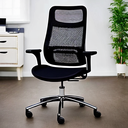

In [18]:
image_sd = agent_generate_image_product_sd("mesh chair")

# Display the image
image = Image.open(image_sd)
width, height = image.size
new_size = (width // 4, height // 4)
small_image = image.resize(new_size, Image.LANCZOS)
display(small_image)

100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Here is a summary of the product description and customer reviews for the mesh chair, highlighted in a bullet-point format:

**Key Features:**
- Made of high-density and breathable mesh for comfort and lumbar support.
- Includes thickened explosion-proof seat plate for added comfort.
- Adjustable padded armrests can be flipped up or down for space-saving.
- Features pneumatic seat height adjustment, tilt lock function, and 360-degree swivel.
- Equipped with solid rolling silencer casters for smooth movement.
- Maximum weight capacity of 300 lbs.
- Assembly takes approximately 10-20 minutes with provided instructions and video support.

**Customer Reviews and Sentiment:**
- Generally easy to assemble and made of decent materials.
- Most customers find the chair comfortable and aesthetically pleasing.
- Described as good value for the price.
- Positive reviews regarding fast shipping and prompt delivery.
- Customers appreciate the overall quality and appearance of the chair.
- Rated high

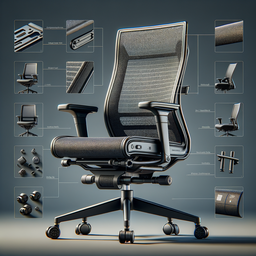

In [20]:
#Call agent with product name to generate image
image_dalle = agent_generate_image_product_dalle("mesh chair")

# Display the image
image = Image.open(image_dalle)
width, height = image.size
new_size = (width // 4, height // 4)
small_image = image.resize(new_size, Image.LANCZOS)
display(small_image)

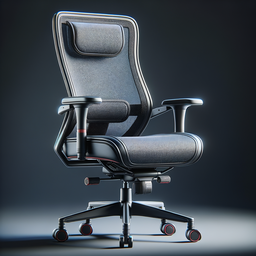

In [20]:
# Open the image
image = Image.open(image_dalle)

# Resize the image to 1/4th of its original size
width, height = image.size
new_size = (width // 4, height // 4)
small_image = image.resize(new_size, Image.LANCZOS)

# Display the smaller image
display(small_image)

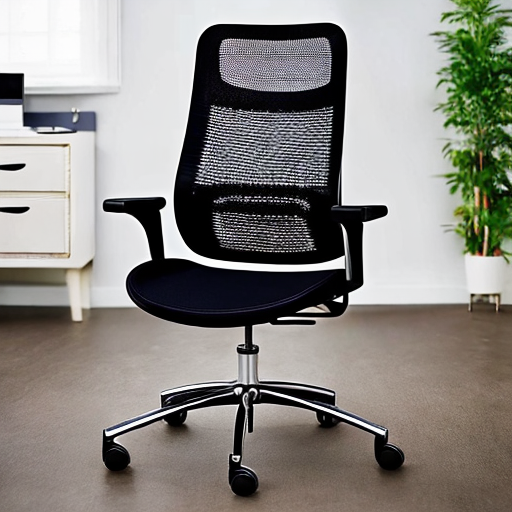

In [21]:
display(Image.open(image_sd))